In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

In [2]:
#define class predict layer
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                    padding=1)

In [3]:
#define bounding box layer
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [4]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10,10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [5]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

In [6]:
def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [7]:
concat_preds([Y1, Y2]).shape

(2, 25300)

In [8]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
               nn.BatchNorm(in_channels=num_channels),
               nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

In [9]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

In [10]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [11]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalAvgPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [12]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [13]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], 
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [14]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors,
                                                     num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        return (nd.concat(*anchors, dim=1), 
                   concat_preds(cls_preds).reshape(
                   (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

In [16]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


In [17]:
#define training
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)

In [18]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.2,
                                                     'wd':5e-4})

In [21]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

In [25]:
def cls_eval(cls_preds, cls_labels):
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [27]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, cls_preds, bbox_preds = net(X)
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                         bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size
    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1- acc_sum / n, mae_sum /m, time.time() - start))

epoch  5, class err 3.12e-03, bbox mae 3.28e-03, time 8.5 sec
epoch 10, class err 2.87e-03, bbox mae 3.04e-03, time 8.3 sec
epoch 15, class err 2.64e-03, bbox mae 2.84e-03, time 8.5 sec
epoch 20, class err 2.54e-03, bbox mae 2.79e-03, time 8.5 sec


In [28]:
#predict
img = image.imread('../img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [29]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

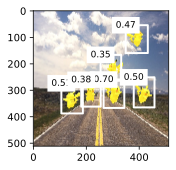

In [32]:
d2l.set_figsize()

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
display(img, output, threshold=0.3)